In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc

In [2]:
student_performance=pd.read_csv('Student_Performance.csv')

In [3]:
num_samples=5000

np.random.seed(42) # for reproducibility

data = {
    'Student_ID' : [i for i in range(1,num_samples+1)],
    'inactivity_score': np.random.randint(0, 101, num_samples),
    'poor_performance_score': np.random.randint(0, 101, num_samples),
    'inconsistent_engagement_score': np.random.randint(0, 101, num_samples),
    'study_hours_per_week': np.random.randint(0, 41, num_samples),
    'attendance_rate': student_performance['attendence_rate'], # Assume minimum 50% attendance
    'previous_failures': np.random.randint(0, 6, num_samples)
}
df = pd.DataFrame(data)

    # Introduce some correlation for 'dropout'
    # Higher inactivity, poor performance, inconsistent engagement, more failures
    # and lower study hours/attendance are more likely to lead to dropout.
dropout_prob = (
    0.05 + # Base dropout probability
    df['inactivity_score'] * 0.002 +
    df['poor_performance_score'] * 0.003 +
    df['inconsistent_engagement_score'] * 0.0025 +
    df['previous_failures'] * 0.05 -
    df['study_hours_per_week'] * 0.005 -
    (100 - df['attendance_rate']) * 0.002
)
dropout_prob = np.clip(dropout_prob, 0.01, 0.99) # Clip probabilities to valid range

df['dropout'] = (np.random.rand(num_samples) < dropout_prob).astype(int)

print(f"Generated a synthetic dataset with {num_samples} samples.")
print("Dataset head:")
print(df.head())
print("\nDropout distribution:")
print(df['dropout'].value_counts())
print("-" * 50)

Generated a synthetic dataset with 5000 samples.
Dataset head:
   Student_ID  inactivity_score  poor_performance_score  \
0           1                51                      62   
1           2                92                      21   
2           3                14                      10   
3           4                71                      57   
4           5                60                      56   

   inconsistent_engagement_score  study_hours_per_week  attendance_rate  \
0                             56                     4               68   
1                             45                    15               98   
2                              7                     6               57   
3                              9                     0               70   
4                             72                     8               80   

   previous_failures  dropout  
0                  1        1  
1                  5        1  
2                  4        0  
3  

In [4]:
df.to_csv('dropout_risk.csv',index=False)

In [5]:
dropout=pd.read_csv('dropout_risk.csv')
dropout

,Student_ID,inactivity_score,poor_performance_score,inconsistent_engagement_score,study_hours_per_week,attendance_rate,previous_failures,dropout
0,1,51,62,56,4,68,1,1
1,2,92,21,45,15,98,5,1
2,3,14,10,7,6,57,4,0
3,4,71,57,9,0,70,2,0
4,5,60,56,72,8,80,4,0
...,...,...,...,...,...,...,...,...
4995,4996,36,9,47,17,51,3,0
4996,4997,78,5,61,7,68,5,0
4997,4998,91,12,96,14,90,0,0
4998,4999,17,64,59,40,66,3,1


In [6]:
X = dropout.drop('dropout', axis=1)
y = dropout['dropout']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (4000, 7)
Testing data shape: (1000, 7)


In [6]:
# --- 2. Train XGBoost Classifier ---
print("Training XGBoost Classifier...")
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)
print("XGBoost Classifier trained successfully.")
print("-" * 50)


Training XGBoost Classifier...


c:\Users\simra\OneDrive\Documents\Final_Project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:59:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classifier trained successfully.
--------------------------------------------------


In [7]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] 

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")
print("-" * 50)

True Negatives (TN): 433
False Positives (FP): 169
False Negatives (FN): 215
True Positives (TP): 183
--------------------------------------------------


In [8]:
fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
print(f"False Positive Rate (FPR): {fpr:.4f}")

# False Negative Rate (FNR): FN / (FN + TP)
# It's the proportion of actual positives that were incorrectly classified as negative.
fnr = fn / (fn + tp) if (fn + tp) != 0 else 0
print(f"False Negative Rate (FNR): {fnr:.4f}")
print("-" * 50)

False Positive Rate (FPR): 0.2807
False Negative Rate (FNR): 0.5402
--------------------------------------------------


Plotting Precision-Recall Curve...


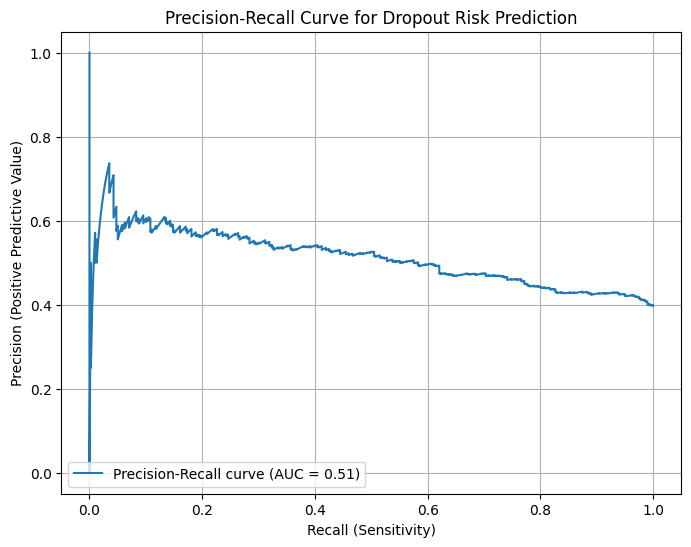

In [9]:
# --- 4. Plot Precision-Recall Curve ---
print("Plotting Precision-Recall Curve...")
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (Positive Predictive Value)')
plt.title('Precision-Recall Curve for Dropout Risk Prediction')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

Feature Importances:
                         feature  importance
6              previous_failures    0.190780
2         poor_performance_score    0.149543
3  inconsistent_engagement_score    0.144477
1               inactivity_score    0.141089
4           study_hours_per_week    0.130404
5                attendance_rate    0.126269
0                     Student_ID    0.117438


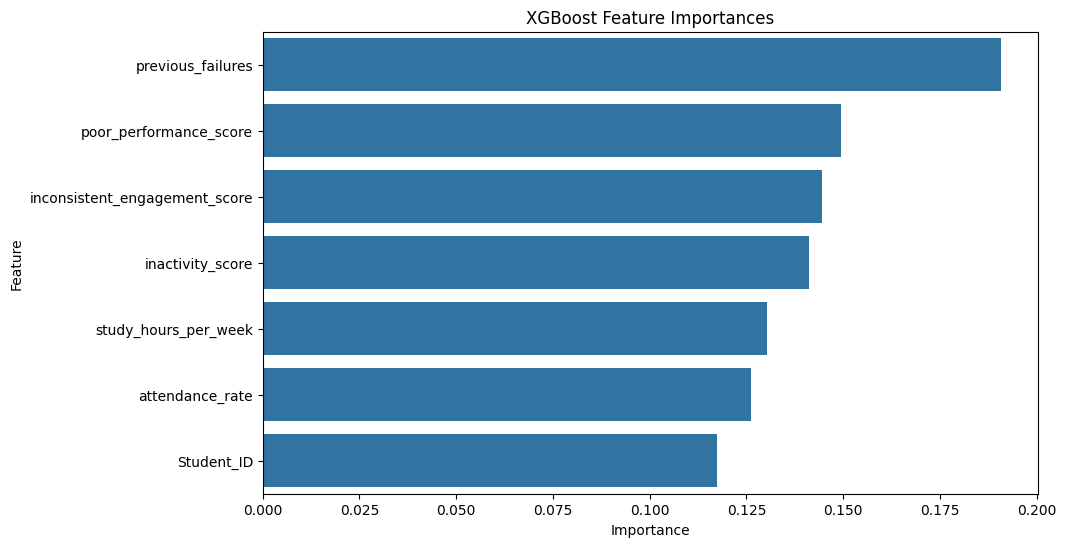

In [10]:
# --- Analyze Model Importance (as requested in the image) ---
print("Feature Importances:")
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

print(feature_importances)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('XGBoost Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [11]:
import pickle

with open ('XGB_classifier.pkl','wb') as file:
    pickle.dump(model, file)

In [13]:
dropout.head()

,Student_ID,inactivity_score,poor_performance_score,inconsistent_engagement_score,study_hours_per_week,attendance_rate,previous_failures,dropout
0,1,51,62,56,4,72,1,1
1,2,92,21,45,15,51,5,1
2,3,14,10,7,6,55,3,0
3,4,71,57,9,0,78,2,0
4,5,60,56,72,8,76,3,1


In [1]:
%%writefile dropout.py
import streamlit as st 
import pandas as pd 
import numpy as np
import pickle


st.title('Dropout Risk Predictor')

model= pickle.load(open('XGB_classifier.pkl', 'rb'))

student_id=st.number_input('Student ID')
inactivity_score=st.number_input('Inactivity Score')
poor_performance_score=st.number_input('Poor Score')
inconsistent_engagement_score=st.number_input('Inconsistent Engagement Score')
study_hpurs_per_week=st.number_input('Study Hours Spent per Week')
attendance_rate=st.number_input('Attendance Percentage')
previous_failures=st.number_input('Previous Failures')

if st.button('Dropout Predictor'):
        input_data=np.array([student_id,inactivity_score,poor_performance_score,inconsistent_engagement_score,study_hpurs_per_week,attendance_rate,previous_failures])
        input_data=input_data.reshape(1,-1)

        prediction=model.predict(input_data)
        st.success(f'Prediction : {prediction}')



Overwriting dropout.py


In [2]:
!streamlit run dropout.py

^C
